## **IResNetSE**

In [15]:
import torch
from models.IRSeNet import IRSeNet
from models.MobileNet import MobileNet

In [22]:
model = torch.load('/workspace/SurveillanceAI/src/arcface/weights/mobilenet.pt')
model

MobileNet(
  (model): MobileFaceNet(
    (conv1): Conv_block(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (conv2_dw): Conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (conv_23): Depth_Wise(
      (conv): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=128)
      )
      (conv_dw): Conv_block(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
        (bn): BatchNorm2d

In [23]:
# count no of parameters'
total_params = sum(p.numel() for p in model.parameters())
total_params

1200512

## **Testing**

In [24]:
path = "/workspace/SurveillanceAI/src/arcface/data/faces"

from PIL import Image

image1 = Image.open('/workspace/SurveillanceAI/src/arcface/data/faces/abhay_deol/28d6f9c369.jpg')
image2 = Image.open('/workspace/SurveillanceAI/src/arcface/data/faces/priyanka_chopra/211a674ca7.jpg')
image3 = Image.open('/workspace/SurveillanceAI/src/arcface/data/faces/priyanka_chopra/0c1f1d77de.jpg')

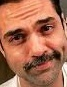

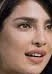

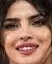

In [25]:
display(image1, image2, image3)

In [26]:
# convert image1 to pytorch tensor
import torchvision.transforms as transforms
transform = transforms.Compose([
        transforms.Resize((112, 112), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225]),
    ])

In [27]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

with torch.no_grad():
    model.eval()
    tensor1 = transform(image1).unsqueeze(0)
    tensor2 = transform(image2).unsqueeze(0)
    tensor3 = transform(image3).unsqueeze(0)
    t1 = model(tensor1)
    t2 = model(tensor2)
    t3 = model(tensor3)
    
    print(cos(t1, t2), cos(t3, t2))

tensor([0.2819]) tensor([0.4093])
